## 2. Logistic Regression with Theano


The aim of this IPython notebook is to show some features of the Python **Theano** library in the field of machine learning. It has been developped by the LISA group at the *University of Montreal* (see: http://deeplearning.net/software/theano/). The notebook also relies on other standard Python libraries such as *numpy*, *pandas* and *matplotlib*.

To exemplify the use of **Theano**, this notebook solves the assignments of the *Machine Learning* MOOC provided by **Coursera** (see: https://www.coursera.org/learn/machine-learning) and performed in *Stanford University* by **Andrew Ng** (see: http://www.andrewng.org/).

The original MOOC assignments should to be programmed with the **Octave** language (see: https://www.gnu.org/software/octave/).The idea with this notebook is to provide Python developpers with interesting examples programmed using **Theano**.

This notebook has been developped using the *Anaconda* Python 3.4 distribution provided by **Continuum Analytics** (see: https://www.continuum.io/). It requires the **Jupyter Notebook** (see: http://jupyter.org/).

About the author: **Francis Wolinski** has an Engineering Degree From *Ecole des Ponts ParisTech* as well as a MSc. in Artificial Intelligence and a PhD. in Computer Science from *Université Pierre et Marie Curie* (UPMC).

### 2.1 Standard Logistic Regression

#### 2.1.1 Visualizing the data

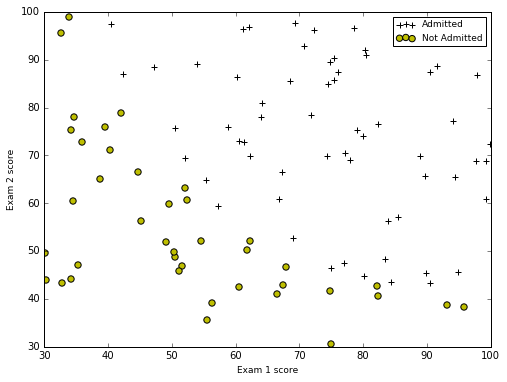

In [1]:
import pandas as pnd
import matplotlib.pyplot as plt
%matplotlib inline

df = pnd.read_csv('data/ex2data1.txt', header=None)
df.columns = ['Exam1', 'Exam2', 'Admitted']
plt.figure(figsize=(8,6))
plt.scatter(df[df['Admitted']==1]['Exam1'], df[df['Admitted']==1]['Exam2'], \
            s=40, marker='+', color='k', label='Admitted');
plt.scatter(df[df['Admitted']==0]['Exam1'], df[df['Admitted']==0]['Exam2'], \
            s=40, marker='o', color='y', label='Not Admitted', edgecolors='k');
plt.xlabel('Exam 1 score', fontsize=9)
plt.ylabel('Exam 2 score', fontsize=9)
plt.axis((30, 100, 30, 100))
plt.legend(fontsize=9);

#### 2.1.2 Cost function and gradient

Unlike in the assignment which use the Octave fminunc function to learn the parameters, they are learned using the gradient descent method.

In [2]:
import theano
import numpy as np
import theano.tensor as T

# Feature Normalization
mu = df.mean()
sigma = df.std()
df2 =(df - mu)/sigma

# Training Data
m = df.shape[0]
Xnorm = np.matrix([np.ones(m), df2["Exam1"].values, df2["Exam2"].values]) # Add intercept term to X
Y = df["Admitted"].values

# Choose some alpha value
alpha = 0.01

# Init Theta and Run Gradient Descent 
t = np.zeros(3)
theta = theano.shared(t,name='theta')

x = T.matrix('x')
y = T.vector('y')

h = 1.0 / (1.0 + T.exp(-T.dot(theta,x)))
cost = -T.sum(y * T.log(h) + (1.0 - y) * T.log (1.0 - h))/m
grad = T.grad(cost,theta)

train = theano.function([x,y],cost,updates = [(theta,theta-alpha*grad)])

costM = train(Xnorm,Y)
print('Cost at initial theta (zeros): %f\n' % costM);
print('Gradient at initial theta (zeros): \n');
print(theta.get_value())

Cost at initial theta (zeros): 0.693147

Gradient at initial theta (zeros): 

[ 0.001       0.00279819  0.00249728]


#### 2.1.3 Gradient Descent

In [3]:
# Choose some alpha value
alpha = 0.1
num_iters = 5000
for i in range(num_iters):
    costM = train(Xnorm,Y)

print('Cost at theta found by gradient descent: %f\n' % costM);
print('theta:');
print(theta.get_value())

Cost at theta found by gradient descent: 0.224718

theta:
[ 1.00126771  2.49576049  2.28158342]


In [4]:
# Predict values for a student with an Exam 1 score of 45 and an Exam 2 score of 85
X0 = np.array([1, (45 - mu['Exam1'])/sigma['Exam1'], (85 - mu['Exam2'])/sigma['Exam2']])
prediction = np.dot(theta.get_value(), X0)
print('For a student with scores 45 and 85, we predict an admission probability of %f' % prediction)
# number of positive predictions where Y==1
accuracy = np.sum(1*(np.dot(theta.get_value(), Xnorm)>0)==Y)/Y.size
print('\nTrain Accuracy: %f' % accuracy)

For a student with scores 45 and 85, we predict an admission probability of 0.658934

Train Accuracy: 0.890000


#### 2.1.4 Plotting data with decision boundary

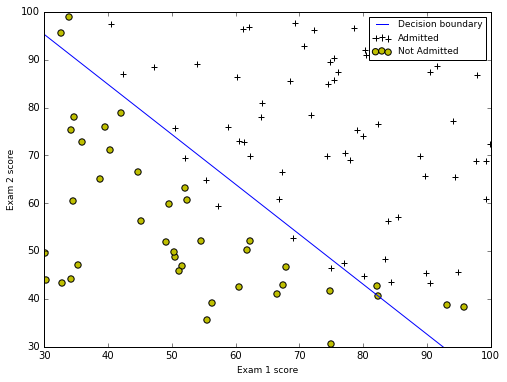

In [5]:
x = T.vector('x')
t = theta.get_value()
a = np.linspace(30,100,2)
# boundary equation : theta x Xnorm = 0
# boundary equation : theta0 + theta1 * (a - mu1)/sigma1 + theta2 * (b - mu2)/sigma2 = 0
b = mu['Exam2'] - sigma['Exam2']/t[2]*(t[0] + t[1]*(x-mu['Exam1'])/sigma['Exam1'])
boundary = theano.function([x],b)
plt.figure(figsize=(8,6))
plt.scatter(df[df['Admitted']==1]['Exam1'], df[df['Admitted']==1]['Exam2'], \
            s=40, marker='+', color='k', label='Admitted');
plt.scatter(df[df['Admitted']==0]['Exam1'], df[df['Admitted']==0]['Exam2'], \
            s=40, marker='o', color='y', label='Not Admitted', edgecolors='k');
plt.plot(a, boundary(a), 'b', label='Decision boundary')
plt.xlabel('Exam 1 score', fontsize=9)
plt.ylabel('Exam 2 score', fontsize=9)
plt.axis((30, 100, 30, 100))
plt.legend(fontsize=9);

### 2.2 Regularized logistic regression

#### 2.2.1 Visualizing the data

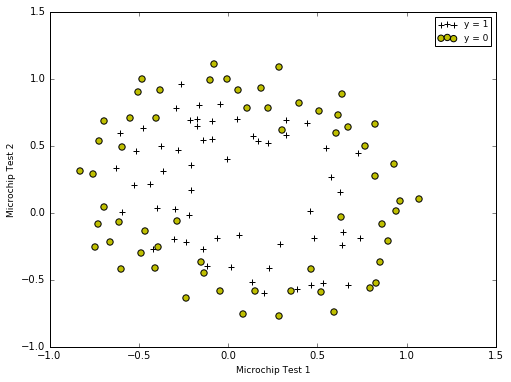

In [6]:
df2 = pnd.read_csv('data/ex2data2.txt', header=None)
df2.columns = ['Test1', 'Test2', 'Accepted']
plt.figure(figsize=(8,6))
plt.scatter(df2[df2['Accepted']==1]['Test1'], df2[df2['Accepted']==1]['Test2'], \
            s=40, marker='+', color='k', label='y = 1');
plt.scatter(df2[df2['Accepted']==0]['Test1'], df2[df2['Accepted']==0]['Test2'], \
            s=40, marker='o', color='y', label='y = 0', edgecolors='k');
plt.xlabel('Microchip Test 1', fontsize=9)
plt.ylabel('Microchip Test 2', fontsize=9)
plt.axis((-1, 1.5, -1, 1.5))
plt.legend(fontsize=9);

### 2.2.2 Feature mapping

In [7]:
def map_feature(x1, x2):
    """
    Maps the two input features
    to quadratic features used in the regularization exercise.
 
    Returns a new feature array with 27 features: 
    X1, X2, X1**2, X1*X2, X2**2, X1*X2**2, ... X1**6, X2**6
 
    Inputs X1, X2 must be the same size
    """
    degree = 6
    df = pnd.DataFrame(np.ones(x1.shape[0]))
    c = 1
    for i in range(1, degree + 1):
        for j in range(i + 1):
            df[c] = (x1 ** (i - j)) * (x2 ** j)
            c += 1
    return df.as_matrix().T

### 2.2.3 Cost function and gradient

In [8]:
# Training Data
m = df2.shape[0]
X = map_feature(df2['Test1'].values, df2['Test2'].values)
Y = df2["Accepted"].values

# Choose some alpha and lambda values
alpha = 0.1
lambda_ = 1.0

# compute theta * theta without first parameter which is not regularized
I = np.eye(X.shape[0])
I[0,0] = 0

# Init Theta and Run Gradient Descent 
t = np.zeros(X.shape[0])
theta = theano.shared(t,name='theta')

x = T.matrix('x')
y = T.vector('y')

h = 1.0 / (1.0 + T.exp(-T.dot(theta,x)))
reg = lambda_ * T.dot(T.dot(I,theta),T.dot(I,theta)) / 2 / m # regularization term
cost = -T.sum(y * T.log(h) + (1.0 - y) * T.log (1.0 - h))/m + reg
grad = T.grad(cost,theta)

train = theano.function([x,y],cost,updates = [(theta,theta-alpha*grad)])

costM = train(X,Y)
print('Cost at initial theta (zeros): %f' % costM)

num_iters = 5000
for i in range(num_iters):
    costM = train(X,Y)
    
# number of positive predictions where Y==1
accuracy = np.sum(1*(np.dot(theta.get_value(), X)>0)==Y)/Y.size
print('\nTrain Accuracy: %f' % accuracy)

Cost at initial theta (zeros): 0.693147

Train Accuracy: 0.830508


### 2.2.4 Plotting the decision boundary

In [9]:
t = theta.get_value()
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))
for i, u1 in enumerate(u):
    for j, v1 in enumerate(v):
        z[i,j] = np.dot(t, map_feature(np.array([u1]), np.array([v1])))
z = z.T

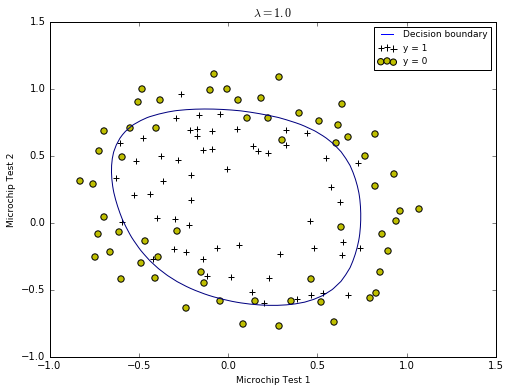

In [10]:
plt.figure(figsize=(8,6))
plt.title('$\lambda = %.1f$' % lambda_)
plt.contour(u, v, z, levels=[0], color='b')
plt.plot([],[], color='b', label='Decision boundary')
plt.scatter(df2[df2['Accepted']==1]['Test1'], df2[df2['Accepted']==1]['Test2'], \
            s=40, marker='+', color='k', label='y = 1');
plt.scatter(df2[df2['Accepted']==0]['Test1'], df2[df2['Accepted']==0]['Test2'], \
            s=40, marker='o', color='y', label='y = 0', edgecolors='k');
plt.xlabel('Microchip Test 1', fontsize=9)
plt.ylabel('Microchip Test 2', fontsize=9)
plt.axis((-1, 1.5, -1, 1.5))
plt.legend(fontsize=9);